In [1]:
from gnn_tracking.training.ec import ECModule
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_data
from gnn_tracking.analysis.graphs import get_cc_labels

import scienceplots

import matplotlib.pyplot as plt

plt.style.use(("science", "notebook"))

In [2]:
module = ECModule.load_from_checkpoint(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/adorable-dalmatian-of-rain/checkpoints/epoch=19-step=144000.ckpt",
    map_location="cpu"
)

[12:16:59] DEBUG: Getting class EFMLP from module gnn_tracking.models.edge_filter
[12:16:59] DEBUG: Getting class HaughtyFocalLoss from module gnn_tracking.metrics.losses


In [3]:
from gnn_tracking.utils.loading import TrackingDataModule
dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_9/"
        ],
        stop=2
    ),
)
dm.setup(stage="fit")

[12:16:59] INFO: DataLoader will load 900 graphs (out of 900 available).
[12:16:59] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_1/data21999_s0.pt
[12:16:59] INFO: DataLoader will load 2 graphs (out of 1000 available).
[12:16:59] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v6/part_9/data29001_s0.pt


## New

In [4]:
from gnn_tracking.utils.dictionaries import add_key_suffix
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats
from gnn_tracking.utils.graph_masks import get_edge_mask_from_node_mask, \
    get_good_node_mask
from tqdm import tqdm
from gnn_tracking.metrics.cluster_metrics import flatten_track_metrics
import pandas as pd

def _get_maximum_dm_stats(data, module, cutoffs):
    results = []
    weights = module(data)["W"]
    for cutoff in cutoffs:
        dc = data.edge_subgraph(weights > cutoff)
        y = dc.y.bool()
        ei = dc.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        r= flatten_track_metrics(
            tracking_metrics_data(
                dc, labels.detach().cpu().numpy(), [0.9]
            )
        )
        r["threshold"] = cutoff
        edge_mask = get_edge_mask_from_node_mask(
            get_good_node_mask(data, pt_thld=0.9, max_eta=4), data.edge_index
        )
        bcs_thld = BinaryClassificationStats(
            output=weights[edge_mask], y=data.y[edge_mask].long(), thld=cutoff
        )
        bcs = BinaryClassificationStats(
            output=weights, y=data.y.long(), thld=cutoff
        )
        r |= add_key_suffix(bcs_thld.get_all(), "_thld")
        r |= bcs.get_all()
        results.append(r)
    return pd.DataFrame.from_records(results)


def get_maximum_dm_stats(module, dataloader, cutoffs):
    results = []
    for data in tqdm(dataloader):
        results.append(_get_maximum_dm_stats(data, module, cutoffs))
    dfs_concat = pd.concat(results)
    cols = dfs_concat.columns
    df = dfs_concat.groupby("threshold").agg(["mean", "std", "size"]).reset_index()
    for c in cols:
        if c == "threshold":
            continue
        mean = df[(c, "mean")]
        df[f"{c}_err"] = df[(c, "std")] / (df[(c, "size")] ** 0.5)
        df.drop(columns=[(c, "mean"), (c, "std"), (c, "size")], inplace=True)
        df[c] = mean
    return df




In [5]:
import numpy as np

df = get_maximum_dm_stats(module, dm.val_dataloader(), np.linspace(0., 0.5, 101))

  0%|                                                                                                                                                                                                                         | 0/2 [00:00<?, ?it/s]/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:02<00:00, 121.05s/it]


In [6]:
from ocpaper231.names import variable_manager as vm

In [7]:
import matplotlib.pyplot as plt

class ThresholdPossibilityInfoPlot:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self._legend_items = []
        self.fig, ax = plt.subplots()
        ax.set_xlabel("EC threshold")
        self.ax = ax
        self.log_ax = ax.twinx()
        self.log_ax.set_yscale("log")
        self.log_ax.set_ylabel("FPR", color="C3")
        self.log_ax.tick_params(axis='y', labelcolor="C3")

    def plot(self):
        self.plot_dm()
        self.plot_perfect()
        self.plot_tpr_fpr()
        self.add_legend()

    def plot_errorline(self, key, label="", ax=None, **kwargs):
        if ax is None:
            ax = self.ax
        line, *_ = ax.plot(
            self.df.threshold,
            self.df[key],
            **kwargs,
        )
        color = line.get_color()
        shading = ax.fill_between(
            self.df.threshold,
            self.df[key] - self.df[f"{key}_err"],
            self.df[key] + self.df[f"{key}_err"],
            color=color,
            alpha=0.3,
        )
        self._legend_items.append(((line, shading), label))
        return color

    def plot_dm(self):
        self.plot_errorline(
            "double_majority_pt0.9",
            label=r"$\lesssim\, \epsilon^{\mathrm{DM}}_{p_T > 0.9}$",
        )

    def plot_perfect(self):
        self.plot_errorline(
            "perfect_pt0.9",
            label="$\lesssim\, \epsilon^{\mathrm{perfect}}_{p_T > 0.9}$",
        )

    def plot_tpr_fpr(self):
        self.plot_errorline(
            "TPR_thld",
            label=r"$\mathrm{TPR}_{p_T > 0.9, \dots}$",
            ls = "--",
        )
        self.plot_errorline(
            "FPR",
            label="FPR (log scale)",
            ls="--",
            ax=self.log_ax,
            color="C3"
        )

    def add_legend(self):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels)


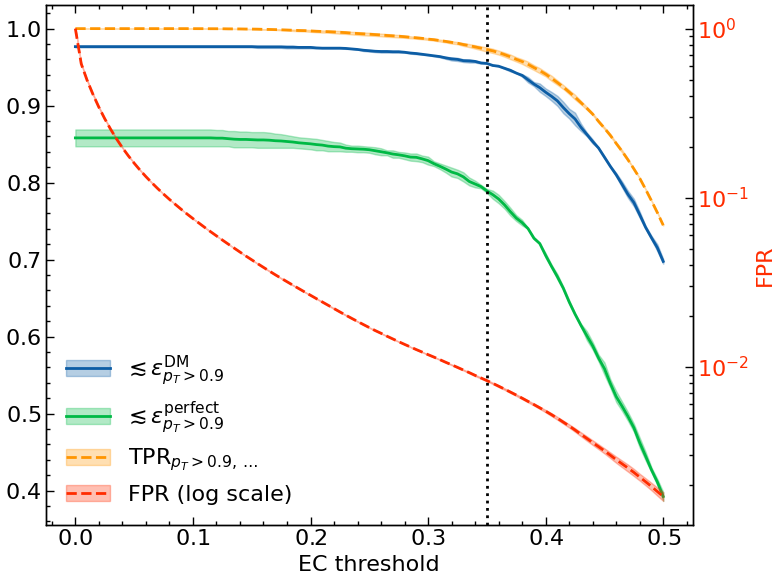

In [8]:
tpip = ThresholdPossibilityInfoPlot(df)
tpip.plot()
tpip.ax.axvline(0.35, color="black", ls=":")
tpip.ax.get_figure().tight_layout()
tpip.ax.get_figure().savefig("tpip.pdf")

In [10]:
tpip.ax.get_figure().get_size_inches()

array([8., 6.])

In [21]:
this_df = df[np.isclose(df["threshold"],0.35)]

In [23]:
for col in ["TPR", "TPR_thld", "FPR"]:
    print(col, this_df[col].item())

TPR 0.41635108714117486
TPR_thld 0.9728459591426462
FPR 0.008304386972784655


In [24]:
fpr_thld_cut = this_df["FPR"].item()

In [25]:
from scipy.integrate import simpson

default_roc_auc = -simpson(df["TPR"], x=df["FPR"])
interest_roc_auc = -simpson(df["TPR_thld"], x=df["FPR"])

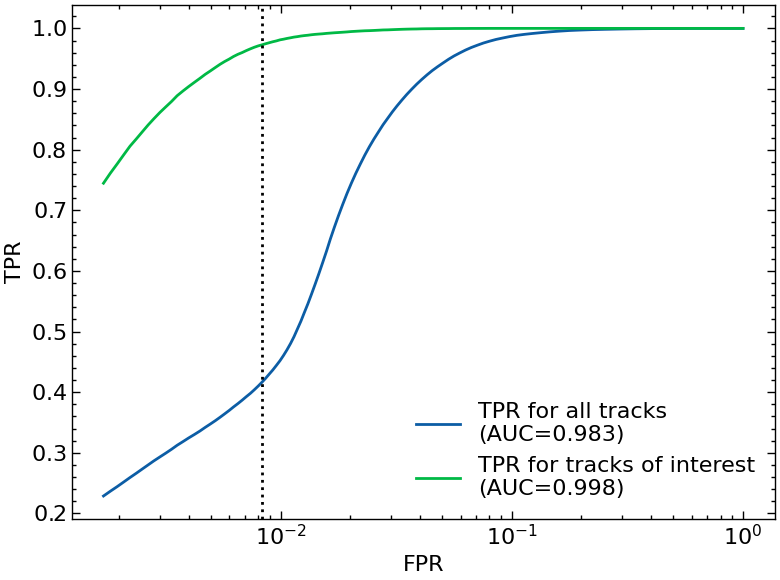

In [26]:
fig, ax = plt.subplots()
ax.plot("FPR", "TPR", data=df, label=f"TPR for all tracks\n(AUC={default_roc_auc:.3f})")
ax.plot("FPR", "TPR_thld", data=df, label=f"TPR for tracks of interest\n(AUC={interest_roc_auc:.3f})")
ax.set_xscale("log")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.axvline(fpr_thld_cut, c="k", ls=":")
ax.legend()
fig.tight_layout()
fig.savefig("ef_roc.pdf");

In [72]:
fig.get_size_inches()

array([8., 6.])

## Old (broken)

Issue: This doesn't take into account sectorization, so the length of the connected component will no longer be a valid upper bound of the DM, so it's misleading

In [13]:
from gnn_tracking.analysis.edge_classification import collect_all_ec_stats
import numpy as np

df = collect_all_ec_stats(module, dm.val_dataloader(), np.linspace(0., 0.4, 40))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
df

,threshold,acc,TPR,TNR,FPR,FNR,balanced_acc,F1,MCC,n_true,...,n_orphan_total_err,frac_segment100_err,frac_component100_err,frac_segment50_err,frac_component50_err,frac_segment75_err,frac_component75_err,n_segments_err,frac_hits_largest_segment_err,frac_hits_largest_component_err
0,0.000000,0.056872,1.000000,0.000000,1.000000,0.000000,0.500000,0.107564,0.000000,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
1,0.010256,0.524321,0.999876,0.495616,0.504384,0.000124,0.747746,0.192766,0.229682,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
2,0.020513,0.665832,0.999466,0.645670,0.354330,0.000534,0.822568,0.253466,0.305761,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
3,0.030769,0.750015,0.998904,0.734955,0.265045,0.001096,0.866930,0.311893,0.368022,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
4,0.041026,0.802893,0.997674,0.791103,0.208897,0.002326,0.894388,0.364721,0.419270,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
5,0.051282,0.838714,0.995951,0.829188,0.170812,0.004049,0.912570,0.411901,0.462537,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
6,0.061538,0.864747,0.994224,0.856897,0.143103,0.005776,0.925561,0.454637,0.500451,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
7,0.071795,0.883998,0.991647,0.877467,0.122533,0.008353,0.934557,0.492187,0.532904,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427
8,0.082051,0.898870,0.988550,0.893423,0.106577,0.011450,0.940987,0.525626,0.561321,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427
9,0.092308,0.911181,0.984232,0.906733,0.093267,0.015768,0.945482,0.556661,0.587260,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427


In [19]:
[c for c in df.columns if c.startswith("n")]

['n_true',
 'n_false',
 'n_predicted_true',
 'n_predicted_false',
 'n_true_thld',
 'n_false_thld',
 'n_predicted_true_thld',
 'n_predicted_false_thld',
 'n_orphan_correct',
 'n_orphan_incorrect',
 'n_orphan_total',
 'n_segments',
 'n_true_err',
 'n_false_err',
 'n_predicted_true_err',
 'n_predicted_false_err',
 'n_true_thld_err',
 'n_false_thld_err',
 'n_predicted_true_thld_err',
 'n_predicted_false_thld_err',
 'n_orphan_correct_err',
 'n_orphan_incorrect_err',
 'n_orphan_total_err',
 'n_segments_err']

In [25]:
df["n"] = df["n_false"] + df["n_true"]
df["frac_predicted_false"] = df["n_predicted_false"] / df["n"]
# assuming 100% acc
df["approx_remaining_false"] = df["n_false"] - df["n_predicted_false"]
df["approx_remaining_frac_false"] = df["approx_remaining_false"] / df["n"]
df[["threshold", "frac_predicted_false", "approx_remaining_frac_false"]]


,threshold,frac_predicted_false,approx_remaining_frac_false
0,0.000000,0.000000,0.943556
1,0.010256,0.468120,0.475436
2,0.020513,0.609789,0.333767
3,0.030769,0.694115,0.249441
4,0.041026,0.747072,0.196484
5,0.051282,0.783052,0.160504
6,0.061538,0.809250,0.134306
7,0.071795,0.828740,0.114816
8,0.082051,0.843943,0.099613
9,0.092308,0.856720,0.086836


In [14]:
from gnn_tracking.analysis.edge_classification import ThresholdTrackInfoPlot

ttip = ThresholdTrackInfoPlot(df)

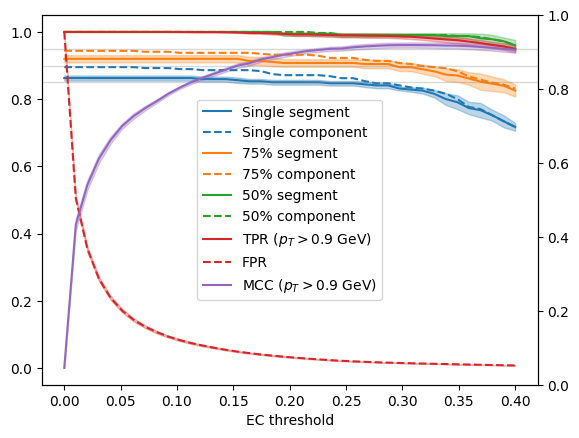

In [16]:
ttip.plot()
ax2 = ttip.ax.twinx()
# ax2.plot(df["threshold"], df["n_predicted_true"], color="red")

In [19]:
df["n_edges"] = df["n_true"] + df["n_false"]

In [22]:
ax2.get_figure().show()

In [42]:
import networkx as nx
from torch import Tensor as T

data =dm.datasets["val"][0]

In [23]:
module(data)["W"].shape

torch.Size([82566])

In [25]:
data.edge_index.shape

torch.Size([2, 82566])

In [43]:


dc = data.edge_subgraph(module(data)["W"] > 0.52)
labels = get_cc_labels(dc.edge_index)
tracking_metrics_data(
    dc, labels.detach().cpu().numpy(), [0.9]
)

{0.9: {'n_particles': 63,
  'n_cleaned_clusters': 41,
  'perfect': 0.2698412698412698,
  'double_majority': 0.5396825396825397,
  'lhc': 0.9024390243902439,
  'fake_perfect': 0.38095238095238093,
  'fake_double_majority': 0.1111111111111111,
  'fake_lhc': 0.0975609756097561}}